# Práctica 1: Aprendizaje automático

__Fecha de entrega: 9 de marzo de 2022__

El objetivo de esta práctica es aplicar los distintos algoritmos de aprendizaje automático disponibles en la scikit-learn [sklearn](https://scikit-learn.org/stable/) sobre varios conjuntos de datos y aprender a interpretar los resultados obtenidos. La práctica consta de 3 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

# Apartado 1: Clustering

__Número de grupo: 2__

__Nombres de los estudiantes: Alberto Almagro Sánchez, Juan Carlos Llamas Núñez y Enrique Rey Gisbert__

## 1) Carga del conjunto de datos

Crea un dataframe a partir del fichero `prestamos.csv` que se proporciona junto con la práctica. 

El conjunto de datos contiene por cada fila los datos de un préstamo que fue concedido por una empresa de crédito p2p. Las variables que caracterizan el préstamo son las siguientes:
  - `loan_amnt` es la cantidad de dinero solicitada en dólares
  - `purpose` es el propósito para el que se solicitó el préstamo
  - `revenue` son los ingresos anuales en dólares de la persona que solicitó el préstamos
  - `dti_n` es el porcentaje de endeudamiento sobre los ingresos anuales de la persona que solicitó el préstamo
  - `fico_n` se trata de un indicador de solvencia de la persona que solicitó el préstamo. A mayor puntuación, mayor solvencia, y además se cuenta con estos rangos orientativoss:
    - 300-550: Pobre
    - 550-620: Subprime (alto riesgo)
    - 620-680: Crédito aceptable
    - 680-740: Buen crédito
    - 740-850: Excelente crédito

  -`home_ownership_n` es una variable categórica que indica la situación de vivienda en la que vive la persona solicitante
    - `OWN` es en propiedad
    - `MORTAGAGE` indica que está hipotecada
    - `RENT` indica que vive en alquiler
    - `OTHER` es una categoría que agrega otras posibilidades

- `emp_length` es una variable ordinal, no es estrictamente numérica, ya que el valor 0 denota que no consta información, los valores entre 1 y 10 indican una permanencia inferior a X años, y el valor 11 indica una permanencia superior a 10 años.
- `Default` es la variable que usaremos como **variable objetivo** del conjunto de datos e indica si la persona incumplió (incurrió en *default*) o no el préstamo.


Como pandas no tiene forma de saber que las variables `home_ownership_n`, `emp_length` y `Default` son en realidad categóricas, debes indicárselo tú.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
df = pd.read_csv('prestamos.csv')
df["home_ownership_n"] = df["home_ownership_n"].astype('category')
df["emp_length_n"] = df["emp_length_n"].astype('category')
df["Default"] = df["Default"].astype('category')
df["purpose"] = df["purpose"].astype('category')
df

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default
0,32000,car,135000.0,18.93,687.0,MORTGAGE,1,0
1,32000,car,90000.0,9.29,822.0,MORTGAGE,10,1
2,30000,car,95000.0,1.34,722.0,RENT,11,0
3,25750,car,230000.0,6.42,747.0,MORTGAGE,11,0
4,25200,car,72000.0,30.95,692.0,OWN,11,0
...,...,...,...,...,...,...,...,...
13789,1275,vacation,42000.0,31.89,792.0,RENT,0,0
13790,1200,vacation,36000.0,12.27,747.0,MORTGAGE,8,0
13791,1000,vacation,76000.0,25.26,702.0,MORTGAGE,11,0
13792,1000,vacation,32000.0,17.70,747.0,MORTGAGE,0,0


## 2) Análisis de los datos

### 2.1) Numéricos

Analiza razonadamente las distribuciones de cada una de las variables numéricas (medias, desviaciones típicas, rangos, ...) y las principales relaciones entre pares de variables (diagrama de dispersión, coeficientes de correlación, ...).

En primer lugar, vamos a intentar comprender algo más sobre las variables numéricas antes de comenzar a trabajar sobre ellas

Empezamos obteniendo una tabla que nos indique los valores de la media, desviación típica, rangos y percentiles de las diferentes variables numéricas con los datos que disponemos. Utilizamos para ello el comando describe() de panda y transpose() para que la lectura de la tabla sea más intuitiva.

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,13794.0,14507.833116,9037.938271,1000.0,7300.0,12000.000,20000.0000,40000.00
revenue,13794.0,79737.299507,56463.579892,7000.0,48000.0,68000.000,97000.0000,1650000.00
dti_n,13794.0,18.825106,9.795986,0.0,12.2,18.085,24.7575,190.87
fico_n,13794.0,699.106822,32.825754,662.0,672.0,692.000,717.0000,847.50


Si analizamos los datos obtenidos, podemos extraer una gran variedad de conclusiones de nuestros datos iniciales.

En primer lugar, la media aritmética nos da una medida promedio de tendencia central que podemos utilizar para hacernos una idea del promedio de los valores que toma cada variable. Sin embargo, no representa como norma general a todo el conjunto de datos ya que no conocemos, por ejemplo, cuanto de separados de esa media estan los datos reales. 

La desviación típica viene a ayudarnos a solucionar este problema, ya que nos da una indicación de la dispersión del conjunto de datos numéricos de cada variable. Si es un valor alto, quiere decir que tenemos datos que se extienden en un rango amplio. Si es un valor bajo, quiere decir que los datos se agrupan cerca de la media. Sin embargo, tampoco es determinante para comprender de forma completa la distribución de los datos, ya que por ejemplo la variable dti_n tiene desviación típica 9.8 pero hay un valor máximo de 190.87, que no esta cerca del rango de valores determinado por la desviación típica.

Finalmente, los percentiles nos ayudan a comprender donde se concentran los valores que toman las variables. Por ejemplo, en el caso de la variable loan_amnt, al ser el 75-percentil 20000 y el máximo de los valores 40000, sabemos que hay tan solo un 25% de valores que están por encima de 20000. También, en el caso de la variable fico_n, al ser el 50-percentil 692 y el mínimo 662, sabemos que hay concentrados en ese rango la mitad de todos los valores que toma esta variable en los datos.

Combinando todas estas medidas estadísticas, podemos hacernos una idea de la distribución que tienen los datos de cada variable, siempre teniendo en mente que no nos dan un conocimiento completo de los mismos. Con la media, desviación típica y el rango min-max podemos, por ejemplo, determinar que la variable revenue comprende un rango amplio de valores debido a que la media es 79737.3 y su desviación típica 56463.58. En cambio, la variable fico_n concentra sus valores en el rango 660-850 puesto que tiene una baja desviación típica de 32.83 con media 699.1 en el rango min-max de 662-847.5.

Ahora, utilizamos corr() para ver la correlación entre nuestras variables numéricas.

In [4]:
df.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,loan_amnt,revenue,dti_n,fico_n
loan_amnt,1.0,0.42,0.034,0.091
revenue,0.42,1.0,-0.14,0.091
dti_n,0.034,-0.14,1.0,-0.058
fico_n,0.091,0.091,-0.058,1.0


Introduzcamos primero algunos conceptos de correlación de variables, y veamos cómo opera el comando corr().

Por defecto, el comando corr() devuelve el coeficiente de correlación de Pearson que mide la dependencia lineal entre cada par de variables (notar que la tabla es simétrica). Este coeficiente está en el rango [-1,1] y se calcula con la siguiente fórmula:



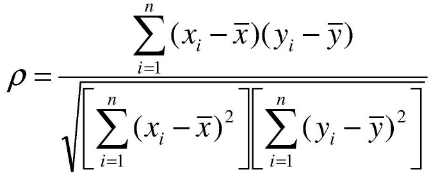

Es muy sencillo de interpretar. Veamos los casos que pueden darse:

    a) Si vale 1, hay dependencia total directa entre las variables.
    b) Si está en el rango (0,1), hay una correlación positiva que es más fuerte cuanto más alto sea el valor.
    c) Si vale 0, noy hay correlación medida por Pearson (aunque CUIDADO, sí puede haber correlación no lineal).
    d) Si está en el rango (-1, 0), hay una correlación negativa que es más fuerte cuanto más bajo sea el valor.
    e) Si vale -1, hay dependencia total inversa entre las variables.
    
Notar que, como es lógico, en la diagonal de la tabla tenemos todo casillas con coeficiente de correlación de Pearson 1, puesto que una variable está en dependencia total directa consigo misma.

En cuanto a los resultados específicos obtenidos en la tabla, comprobamos que las variables revenue y loan_amnt son las que más están correlacionadas positivamente, con un coeficiente de 0.42. Sin embargo, el resto de variables están muy poco correlacionadas entre sí (excepto consigo mismas), puesto que (independientemente de que el coeficiente de Pearson sea positivo o negativo) todos los demás valores son muy cercanos a 0.

Existen otros coeficientes de correlación entre variables, como por ejemplo el coeficiente de correlación de Spearman (que mide correlación monótona, no necesariamente lineal) o el de Kendall (especialmente eficiente para datos discretos). Si probamos a calcularlos para nuestros datos, obtenemos tablas similares a la conseguida con el coeficiente de Pearson:

In [5]:
df.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,loan_amnt,revenue,dti_n,fico_n
loan_amnt,1.0,0.5,0.049,0.088
revenue,0.5,1.0,-0.17,0.095
dti_n,0.049,-0.17,1.0,-0.027
fico_n,0.088,0.095,-0.027,1.0


In [6]:
df.corr(method='kendall').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,loan_amnt,revenue,dti_n,fico_n
loan_amnt,1.0,0.35,0.033,0.061
revenue,0.35,1.0,-0.11,0.065
dti_n,0.033,-0.11,1.0,-0.018
fico_n,0.061,0.065,-0.018,1.0


Por último, presentamos el diagrama de dispersión (scatter matrix) de todos los pares de variables para comprobar cómo están relacionadas visualmente. Para ello, introducimos en nuestra tabla de variables numéricas una columna identificando el tipo de Default (0 o 1) que tiene asociado cada fila.

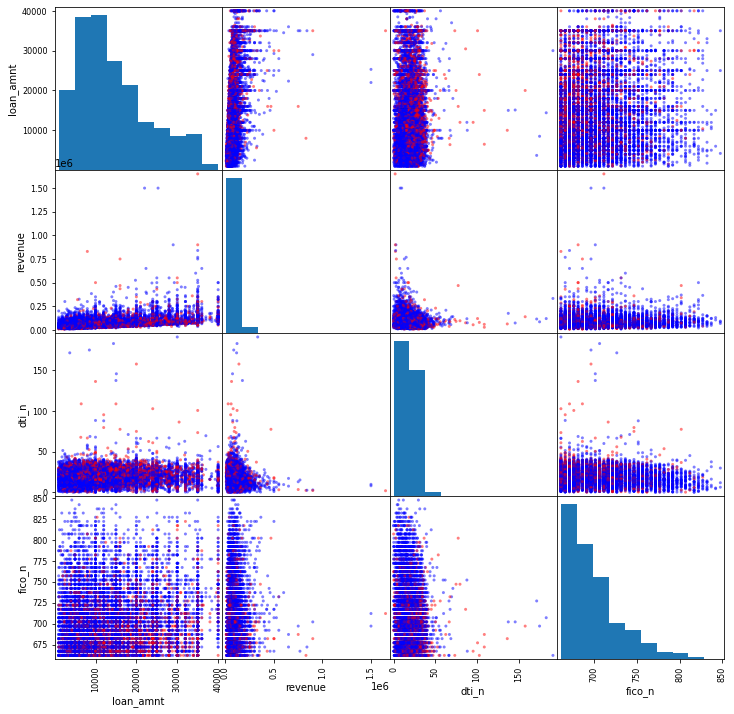

In [7]:
from pandas.plotting import scatter_matrix
%matplotlib inline

dfn = df.loc[:, ['Default','loan_amnt', 'revenue', 'dti_n', 'fico_n']]
dic_target = { 0 : 'Cumplió', 1: 'Incumplió'}
dfn['Default'] = df['Default'].map(dic_target)

dic_colors = { 'Cumplió': 'blue', 'Incumplió': 'red' }
colors = dfn['Default'].map(dic_colors)

scatter_matrix(dfn, figsize = (12, 12), diagonal = 'hist', color=colors)

# Instrucción inútil para que no se muestren datos irrelevantes por ser la anterior la última instrucción
dic_target = dic_target

Las gráficas de la diagonal son histogramas que indican la distribución de los datos para cada variable. El resto de gráficas son los diagramas de dispersión para cada par de variables. Un diagrama de dispersión no es más que un tipo de diagrama matemático que utiliza coordenadas cartesianas para mostrar los valores de dos variables para un conjunto de datos. En nuestro caso, estos gráficos serán relevantes más adelante en los apartados finales cuando describamos los clusters e intentemos visualizarlos.

Hemos asignado color azul a los individuos de filas con Default 0 y color rojo a los individuos de filas con Default 1. En los diagramas de dispersión podemos ver conclusiones que habiamos sacado al analizar la media, desviación típica... de cada variable. Por ejemplo, la variable fico_n se concentra en el rango 660-850 con baja desviación típica, las variables revenue y dti_n tienen unos pocos datos muy alejados de la media (como indicaban los percentiles y el rango min-max de estas variables) y la variable loan_amnt cubre un rango amplio de valores. Es importante resaltar la importancia de la escala en los datos de los diagramas, puesto que pueden inducir a error si no se analiza cuidadosamente. Uno podría pensar que la variable fico_n cubre un rango muy grande de valores, cuando es justo al contrario, o que revenue se concentra en valores muy próximos, cuando hemos visto que tiene desviación típica alta.


### 2.2) Categóricos

Analiza razonadamente las distribuciones de los valores de las variables categóricas incluyendo un diagrama de frecuencias y comentando lo más destacable.

Al igual que hemos hecho para las variables numéricas vamos a intentar comprender algo más sobre las variables no numéricas antes de comenzar a trabajar sobre ellas. En primer lugar estamos interesados en conocer aspectos básicos de la distribución de nuestros datos. Al tratar con variables categóricas que pueden tomar un número finito de valores, nos interesa saber el número de valores que puede tomar cada variable, así como el valor más repetido de cada variable y la frecuencia del mismo. Atenderemos por tanto a las columnas unique, top y freq de la tabla resultado de ejecutar describe() sobre las variables categóricas de nuestro datagrama.

In [8]:
df.describe(include=['category']).transpose()

,count,unique,top,freq
purpose,13794,12,debt_consolidation,7841
home_ownership_n,13794,4,MORTGAGE,6850
emp_length_n,13794,12,11,4612
Default,13794,2,0,10785


Los resultados obtenidos no nos aclaran sustancialmente nuestro problema de entender el comportamiento de los datos, con la excepción de la variable Default. Al tratarse de una variable que únicamente toma dos valores, sabiendo la frecuencia de uno de ellos y el número total de datos, la frecuencia del otro queda totalmente determinada y en una primera aproximación podemos asegurar que, mayoritariamente, los beneficiaros del prestamo no incurrieron en Default (top = 0). Sin embargo este análisis es muy poco fino y es conveniente recurrir a los diagramas de frecuencia para obtener una visión más general.

Comenzamos con el histograma y el gráfico de tarta de la variable 'purpose'.

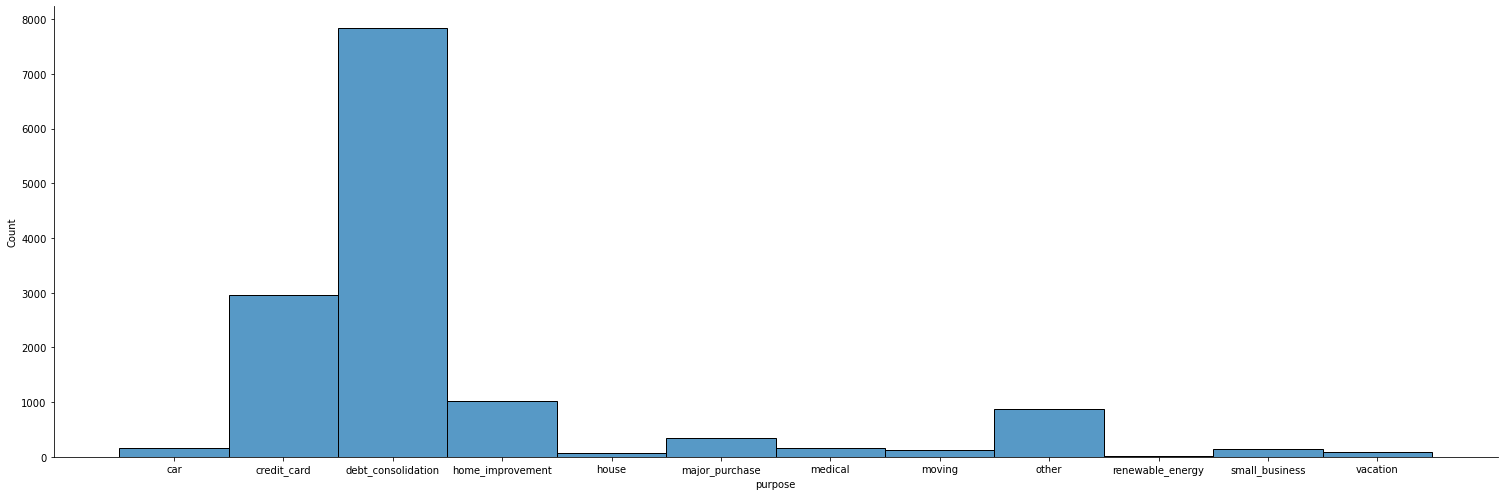

In [9]:
import seaborn as sns
sns.displot(df['purpose'], height=7,aspect = 3)

<AxesSubplot:ylabel='purpose'>

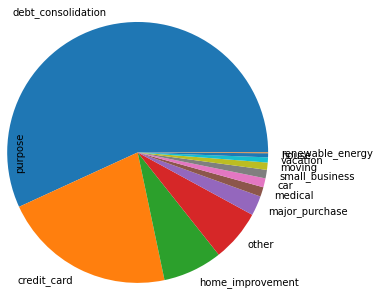

In [10]:
df['purpose'].value_counts().plot.pie(radius=1.5)

Podemos observar que el principal motivo por el que se pide un prestamo es 'debt_consolidation', es decir, para poder pagar otras deudas. Está seguido, a mucha distancia, de 'credit_card'. Entendemos que este valor alude a los prestamos que se piden para abonar deudas pasadas o presentes relacionadas con las tarjetas de crédito. Ambas categorías representan el motivo del préstamo para más de 3/4 de los beneficiarios. Continuamos con la variable home_ownership_n

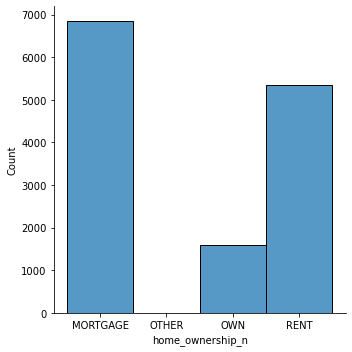

In [11]:
sns.displot(df['home_ownership_n'])

Lo más destacable es que la gran mayoría de las personas que solicitan el préstamo no tienen una vivienda en propiedad, sino que viven de alquiler o tienen la casa hipotecada.

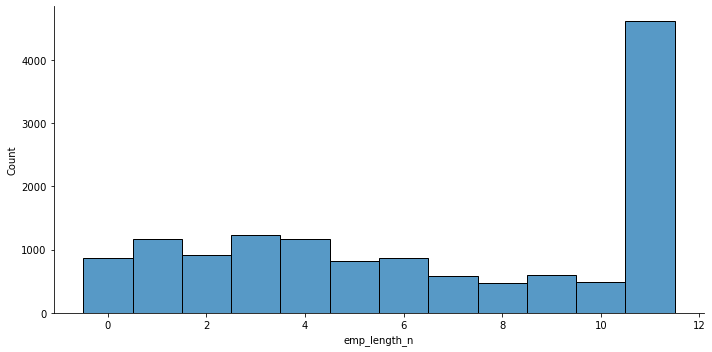

In [12]:
df['emp_length_n']=df['emp_length_n'].cat.as_ordered()
sns.displot(df['emp_length_n'],aspect=2)

Al observar el gráfico superior, correspondiente al histograma de la variable emp_length_n, debemos recordar el porqué de  tratarla como una variable categórica en lugar de numérica. El valor 0 corresponde con falta de información, los valores entre 1 y 10 corresponden a una permanencia inferior a X años, y el valor 11 indica una permanencia superior a 10 años. Para hacer esto más patente podemos hacer lo siguiente:

In [13]:
dic_target2 = { 0 : 'Sin datos', 1 : '1', 2 : '2', 3 : '3', 4 : '4', 5 : '5', 6 : '6', 7 : '7', 8 : '8', 9 : '9', 10 : '10', 11: '+10'}
df['emp_length_n'] = df['emp_length_n'].map(dic_target2)

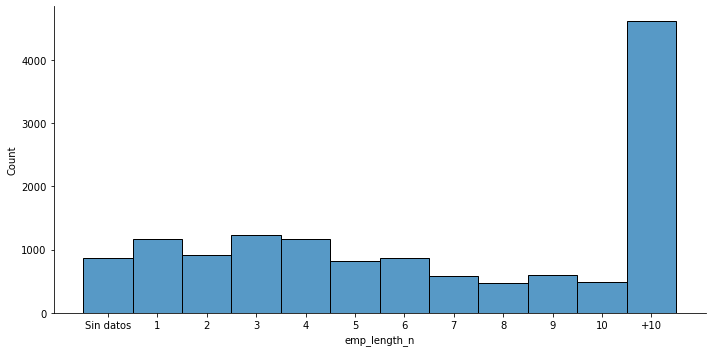

In [14]:
sns.displot(df['emp_length_n'], aspect=2)

Únicamente hemos renombrado las etiquetas del eje x para convertirlas en texto y hemos modificado el valor para las relativas al 0 y al 11 para que su significado sea más intutitivo. Con esta representación ganamos algo más de expresividad. En cuanto a la distribución, podemos decir que mayoritariamente la permanencia es superior a 10 años. En este caso, podría tener sentido y sernos interesante mostrar la distrubución de densidad subyacente para los valores entre 1 y 10.

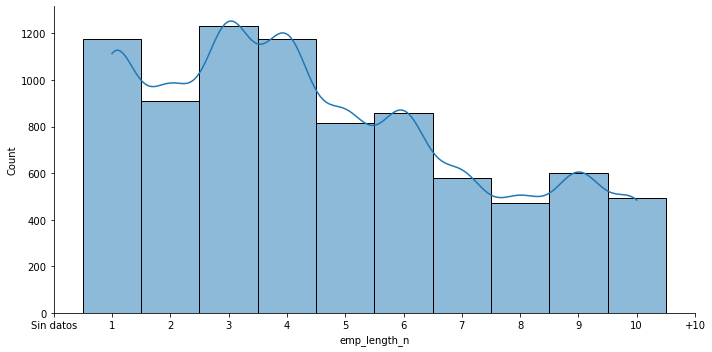

In [15]:
masc1=df['emp_length_n']!='Sin datos'
masc2=df['emp_length_n']!='+10'
sns.displot(df[masc1 & masc2]['emp_length_n'], aspect=2,kde=True)

Por último mostramos la distribución de la variable 'Default'

<AxesSubplot:ylabel='Default'>

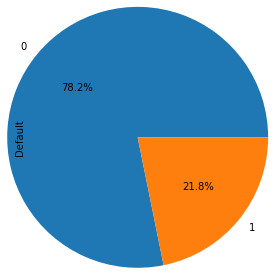

In [16]:
df['Default'].value_counts().plot.pie(radius=1.5,autopct='%1.1f%%',normalize=True)

Finalmente, podemos observar gáficamente lo que antes habíamos anticipado al mirar la moda y su frecuencia en la tabla superior: la mayoría de las personas cumple con el préstamo. Sin embargo un 21.8% en absoluto despreciable no devuelve el préstamo.

Aunque más adelante se especifica que a la hora de construir los clusters solo se van a considerar las variables numéricas y no las categóricas, es importante conocer como deberíamos preprocesar las variables categóricas de cara a usarlas. Habitualmente el procedimiento para converitar las variables categóricas en númericas (binarias concretamente) es realizar una codificación one-hot. Es decir, por cada valor de una variable categórica se incluye una nueva variable numérica que solo puede tomar los valores 0 o 1. Esto se ve más claro con un ejemplo. Para la variable 'home_ownership_n', que hemos visto que puede tomar los valores MORTGAGE, OTHER, OWN o RENT, lo que haríamos sería crear las variables MORTGAGE, OTHER, OWN y RENT que pueden tomar el valor 0 o 1. Entonces, para los datos que cuya variable home_ownership_n tome el valor MORTGAGE, los nuevos valores que tomará para las nuevas variables son MORTGAGE=1, OTHER=0, OWN=0 y RENT=0 y de manera análoga con el resto.

## 3) Preprocesar los datos

Para el clustering vamos a trabajar solamente con las variables verdaderamente numéricas. Crea un nuevo dataframe que sólo contenga las variables `loan_amnt`, `revenue`, `dti_n` y `fico_n`.

Teniendo en cuenta que vamos a utilizar el algoritmo k-Means para encontrar grupos de préstamos similares, explica razonadamente si es necesario o no cambiar la escalas de los datos y si a priori es mejor reescalarlos (MinMaxScaler) o estandarizarlos (StandardScaler).

Si decides preprocesarlos, accede al array interno del dataframe y crea un nuevo array con los datos escalados.

#### Decisión:

Es muy importante que consideremos cambiar la escala de los datos que vamos a tratar, ya que esto afecta en gran medida a los resultados del algoritmo k-Means. En este caso, de no tratar los datos, observamos que, al ser los datos de diferentes columnas muy dispares (por ejemplo, el máximo de la columna revenue es de 1650000 frente a los 190,87 de la columna dti_n), esto se va a corresponder en que a las variables cuyos datos se encuentren en órdenes de magnitud mayores se les va a dar un peso mucho mayor que a las más pequeñas. 

Ahora, ¿cómo elegimos si queremos estandarizar los datos o simplemente reescalarlos? Usando los gráficos que hemos pintado en el apartado 2.1, podemos ver que ninguna de las variables sigue una distribución que se asemeje a la normal, por lo que es mejor que simplemente reescalemos en lugar de estandarizar.

In [17]:
import sklearn.preprocessing as skp

# elegimos entre estandarizar o reescalar los datos
transformer = skp.MinMaxScaler()

# transform data
X = transformer.fit_transform(df.loc[:, ['loan_amnt', 'revenue', 'fico_n', 'dti_n']].to_numpy())

# creamos una lista para poder saber qué representa cada columna
labels = ['loan_amnt','revenue','fico_n','dti_n']

print(X)

[[0.79487179 0.07790627 0.13477089 0.09917745]
 [0.79487179 0.05051735 0.86253369 0.04867187]
 [0.74358974 0.05356056 0.32345013 0.00702049]
 ...
 [0.         0.04199635 0.21563342 0.13234138]
 [0.         0.01521607 0.45822102 0.09273327]
 [0.         0.02921485 0.10781671 0.0780636 ]]


## 4) Encontrar el número óptimo de clusters

Decide razonadamente el número óptimo de clusters en el rango 2..10. Ten en cuenta que para interpretar los datos no nos interesa tampoco tener un número excesivo de clusters. Para hacerlo calcula y pinta el diagrama del codo, el índice davies_boulding y el coeficiente silhouette en función del número de clusters.

Ejecutamos el algoritmo K-Means para los valores de clusters entre 2 y 10. Vamos a aprovechar a guardar los diferentes valores estadísticos que pintaremos después.

In [28]:
K_MAX = 10

KMean = []
davies_boulding = np.zeros(K_MAX-1)
elbow = np.zeros(K_MAX-1)
silhouette = np.zeros(K_MAX-1)
for k in range(2, K_MAX+1):
    km = KMeans(init='random', n_clusters=k, random_state=42)
    km.fit(X)
    KMean.append(km)
    davies_boulding[k-2] = davies_bouldin_score(X, km.labels_) 
    elbow[k-2] = km.inertia_
    silhouette[k-2] = silhouette_score(X, km.labels_, metric='euclidean')

Una vez realizado el algoritmo, podemos pintar el diagrama de codo, el índice davies_boulding y el coeficiente de silueta en función del número de clusters.

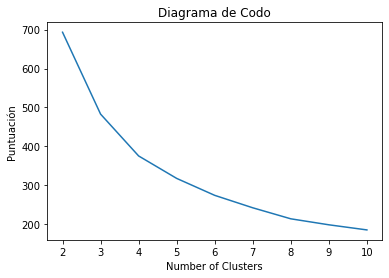

In [29]:
plt.xlabel('Number of Clusters')
plt.ylabel('Puntuación')
plt.title('Diagrama de Codo')
plt.plot(range(2, K_MAX+1),elbow)
plt.show()

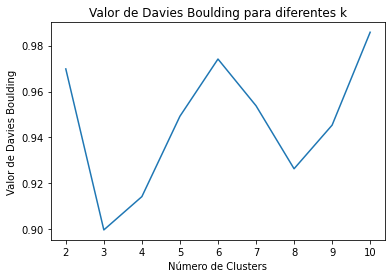

In [20]:
plt.title('Valor de Davies Boulding para diferentes k')
plt.xlabel('Número de Clusters')
plt.ylabel('Valor de Davies Boulding')
plt.plot(range(2, K_MAX+1), davies_boulding)
plt.show()

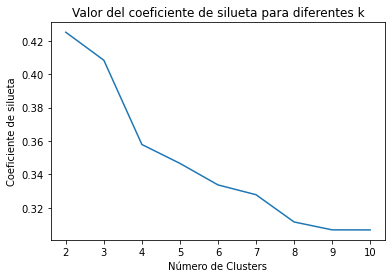

In [21]:
plt.title('Valor del coeficiente de silueta para diferentes k')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de silueta')
plt.plot(range(2, K_MAX+1), silhouette)
plt.show()

Viendo los 3 gráficos notamos que:

- En el diagrama de codo, los valores 3 y 4 parecen ser los óptimos, ya que es donde se producen diferencias notables de la pendiente de la curva.
- En el índice David Boulding, el valor 3 es donde se alcanza el mínimo, lo que lo hace el óptimo.
- En el coeficiente de silueta, los valores 2 y 3 son los mayores, y a partir de 4 el coeficiente disminuye significativamente, lo que indica que el número óptimo de clusters de acuerdo a este indicador es 2 o 3.

Con todo ello, podemos concluir que el valor de k=3 es el óptimo para nuestros datos.

## 5) Descripción de los clusters

Describe los clusters que has obtenido en el apartado anterior. Si te han salido más de 3, elige 3 de ellos que sean bastante diferentes entre sí. 

Para hacerlo estudia sus descriptores estadísticos y dales un sentido dentro del contexto del problema. ¿Qué perfil de préstamos quedan en cada cluster? Según dicho perfil, ¿qué cluster te parece que tendrá una mayor tasa de "default"? Corrobóralo calculando para cada cluster la proporción de préstamos que acabaron en "default".

Pinta el diagrama de dispersión en función de cada par de variables usando colores diferentes para cada cluster. ¿Qué clusters se separan mejor y en función de qué variables? ¿y cuáles se confunden más?

__Cuidado__: para poder interpretar correctamente los datos necesitas que estén en su escala original. Si decidiste escalar los datos, deberás ejecutar k-Means con los datos escalados pero asignar las etiquetas de clusters al conjunto de datos inicial. En este caso es muy sencillo porque el algoritmo no cambia el orden de los datos así que puedes crear directamente una nueva columna en el dataframe original con esas etiquetas. Puede que aparezca un SettingWithCopyWarning por asignar una nueva columna en un dataframe que es una vista de otro dataframe. Puedes ignorar este aviso o puedes hacer una copia del dataframe con `copy` para que no comparta memoria con el otro.

Vamos a realizar proyecciones para observar cómo afecta cada variable a la elección de los clusters.

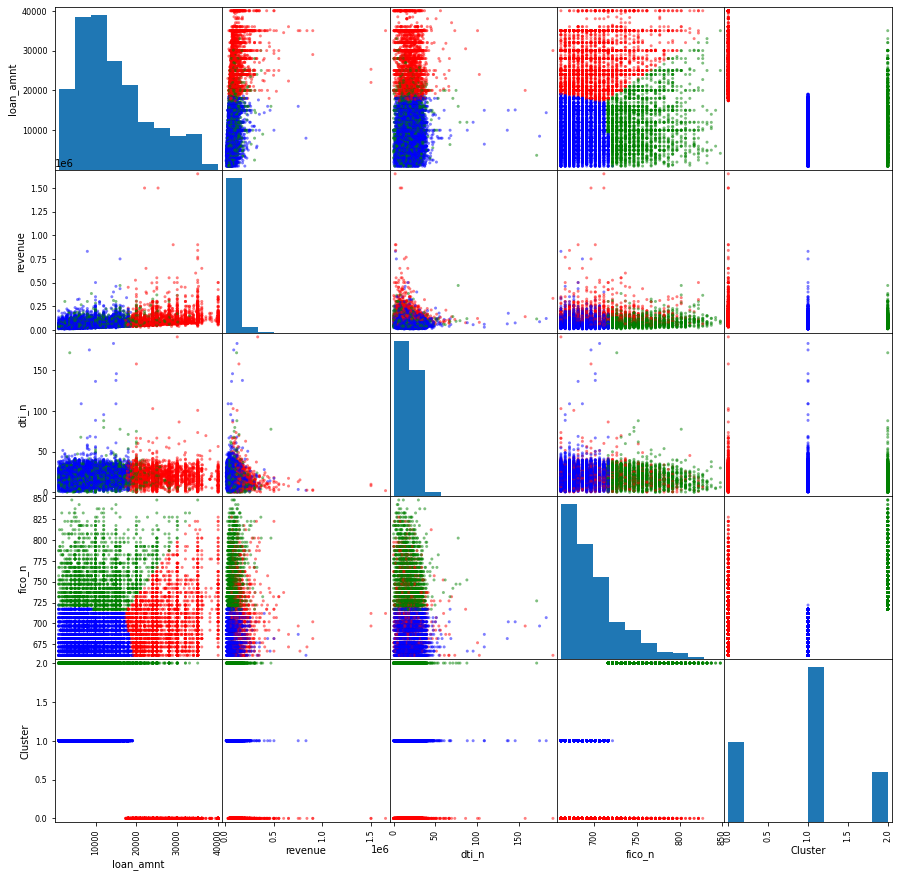

In [22]:
from pandas.plotting import scatter_matrix
%matplotlib inline

OPTIMO = 3

# Tomamos el ajuste con OPTIMO clusters
km = KMean[OPTIMO-2]

dfc = df.loc[:, ['loan_amnt', 'revenue', 'dti_n', 'fico_n']]
dfc['Cluster'] = km.labels_

dic_colors_c = { 0 : 'red', 1: 'blue', 2: 'green' }
colors_c = dfc['Cluster'].map(dic_colors_c)

scatter_matrix(dfc, figsize = (15,15), diagonal = 'hist', color=colors_c)

# Instrucción inútil para que no se muestren datos irrelevantes por ser la anterior la última instrucción
OPTIMO = OPTIMO

Los gráficos que hemos realizado al final de la sección anterior nos muestran cómo distinguir entre los 3 clusters.

- Para valores bajos de loan_amnt y fico_n, se asigna el cluster azul.
- Para valores altos de loan_amnt pero valores bajos de fico_n, se asigna el cluster rojo.
- Para valores altos de fico_n pero valores bajos de loan_amnt, se asigna el cluster verde.

Las variables revenue y dti_n no parecen influir en gran escala en la asignación de clusters.

Recordemos que loan_amnt es la cantidad de dinero solicitada en dólares y fico_n se trata de un indicador de solvencia de la persona que solicitó el préstamo, siendo a mayor puntuación, mayor solvencia. Por tanto, dando esta interpretación a los clusters:

- Los datos encontrados en el cluster verde son aquellos cuya deuda es pequeña y su solvencia es alta, lo que los hace candidatos a cumplir el préstamo.
- Los datos encontrados en el cluster azul son aquellos cuya deuda es pequeña, pero su solvencia también lo es, lo que se traduce en un riesgo medio de incumplir el préstamo.
- Los datos encontrados en el cluster rojo son aquellos cuya deuda es grande y su solvencia es pequeña, lo que los hace muy propensos a incumplir el préstamo.

Para concluir vamos a corroborar nuestra interpretación. Para ello calculamos para cada cluster la proporción de préstamo que acabó en Default. Recordamos que el cluster verde es el cluster 2, el cluster azul es el cluster 1 y el cluster rojo es el cluster 0.

En primer lugar hacemos un análisis genérico de los cluster para lo que utilizamos el comando .describe().

In [23]:
dfc['Default']=df['Default']
dfc.groupby('Cluster').describe(include=['category']).transpose()

Cluster            0     1     2
Default count   3879  7489  2426
        unique     2     2     2
        top        0     0     0
        freq    2866  5787  2132

Podemos observar que el cluster más numeroso es el 1 (azul) y que en todos ellos es mayoritario que no se incurra en default, pero a simple vista no podemos ver la tasa de default. Para ello, los analizamos en más detalle por separado

# Cluster verde

Para el cluster verde (el 2) hemos dicho que representaba deuda pequeña y solvencia alta y que era esperable que la tasa de default sea baja.

<AxesSubplot:ylabel='Default'>

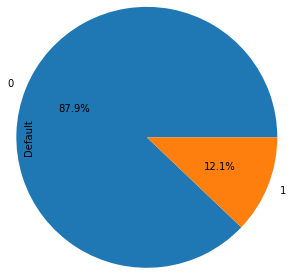

In [24]:
dfc[dfc["Cluster"]==2]['Default'].value_counts().plot.pie(radius=1.5,autopct='%1.1f%%',normalize=True)

Efectivamente, la tasa de Default es de solo el 12.1%. Según veremos, es muy inferior a la de los otros clusters y también es inferior a la tasa media de Default sobre todo los datos, que recordamos era de 21.8%

# Cluster azul

Para el cluster azul (el 1) hemos dicho que representaba deuda y solvencia pequeñas y que era esperable que la tasa de default sea media.

<AxesSubplot:ylabel='Default'>

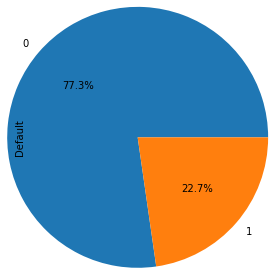

In [25]:
dfc[dfc["Cluster"]==1]['Default'].value_counts().plot.pie(radius=1.5,autopct='%1.1f%%',normalize=True)

En efecto, la tasa de Default es de 22.7% un valor muy similar a la tasa media de Default sobre todo los datos (21.8%)

# Cluster rojo

Para el cluster rojo (el 0) hemos dicho que representaba deuda grande y solvencia pequeña, y que era esperable que la tasa de default sea alta.

<AxesSubplot:ylabel='Default'>

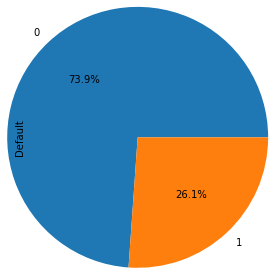

In [26]:
dfc[dfc["Cluster"]==0]['Default'].value_counts().plot.pie(radius=1.5,autopct='%1.1f%%',normalize=True)

De nuevo refrendamos nuestra hipótesis, ya que la tasa de Default es de 26.1%, significativamente mayor que la de los otros clusters y que la media global.